In [6]:
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import requests
import urllib.request
import time

import xlsxwriter
from bs4 import BeautifulSoup
from xlrd import open_workbook


Basic Web scaping Code to find all resturants and shops at the Airport<br>
Main website scapping source here is www.ifly.com




In [99]:

def webscaping(url):
    # Connect to the URL
    response = requests.get(url)
    # Parse HTML and save to BeautifulSoup object¶
    soup = BeautifulSoup(response.text, "html.parser")
    # To download the whole data set, let's do a for loop through all a tags
    line_count = 1 #variable to track what line you are on
    bucketlist=''
    for one_a_tag in soup.findAll('a'):  #'a' tags are for links
        store=str(one_a_tag.get('title'))
        #AMP Tshirt Store at GIG
        if 'at GIG' in store:

            if len(store)<store.rindex('at GIG')+7:
                val=store.replace('at GIG','')
                bucketlist+=str(val+',')
    lst=bucketlist.split(',')
    bucket=set()

    for i in lst:
        if len(i.strip())!=0:
            bucket.add(i)

    workbook = xlsxwriter.Workbook('/Users/PycharmProjects/INF560/Review.xlsx')
    worksheet = workbook.add_worksheet()

    # Start from the first cell.
    # Rows and columns are zero indexed.
    row = 0
    column = 0
    # iterating through content list
    for item in bucket:
        # write operation perform
        worksheet.write(row, column, item)
        # incrementing the value of row by one
        # with each iteratons.
        row += 1
    workbook.close()
    print(len(bucket))
url = 'https://www.ifly.com/antonio-carlos-jobim-international-airport/shops-stores'

webscaping(url)


In [ ]:
# Need to do ....
# Gathering reviews of all the resturant and shops using the results gather above and finding reviews
def webScapingProcessing(excel_file)
    wb = open_workbook(excel_file)
    for s in wb.sheets():
        #print 'Sheet:',s.name
        values = []
        for row in range(s.nrows):
            col_value = []
            for col in range(s.ncols):
                value  = (s.cell(row,col).value)
                try : value = str(int(value))
                except : pass
                col_value.append(value)
            values.append(col_value)
    for elem in values:

        print(elem[1]+" "+elem[0])
webScapingProcessing('/Users/PycharmProjects/INF560/Review.xlsx')

Scape code from Yelp and TripAdvisor website and fetch all reviews of the particaular resturants and cafes and try to find reviews and then apply BLP techiques

In [ ]:
## import requests             
from bs4 import BeautifulSoup 
import csv                  
import webbrowser
import io

def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
        f.write(content)
        webbrowser.open(filename)

def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')
    
def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)
    
    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')
    
def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url + '?filterLang=' + lang)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids
    
def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/Restaurant_Review-g189158-d7593769-Reviews-O_Melhor_Bolo_De_Chocolate_Do_Mundo-Lisbon_Lisbon_District_Central_Portugal.html'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', id='HEADING').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []
    groupIdetifier=['we','us','all','together']

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        if review.find_all('span', class_='comments'):
            comment=review[2].split(" "):
                for i in comment:
                    if i in groupIdetifier:
                        type="Group"
                    else:
                        type="Solo"
            
            
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
        }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='/Users/PycharmProjects/INF560/Review.xlsx',
                  headers=['name', 'Category', 'rating',
                           'Gender', 'Type'],
                  mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)
        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'

start_urls = [
    'https://www.tripadvisor.ca/Hotel_Review-g60982-d87016-Reviews-Hilton_Hawaiian_Village_Waikiki_Beach_Resort-Honolulu_Oahu_Hawaii.html',
]

lang = 'en'

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1, 
]


load in the data set using pandas read_csv() utility

In [7]:
df = pd.read_excel('/Users/PycharmProjects/INF560/Review.xlsx')

In [8]:
#check the head of the data to see the data we are dealing with.


# NLP Procession

In [ ]:
from sklearn.datasets import fetch_20newsgroups
df_train = df(subset='train', shuffle=True)

In [ ]:
df_train.target_names #prints all the categories
print("\n".join(df_train.data[0].split("\n")[:3])) #prints first line of the first data file

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
rom sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])
text_clf = text_clf.fit(df_train.data, df_train.target)

In [ ]:
import numpy as np
df_test = fetch_20newsgroups(subset='test', shuffle=True)
predicted = text_clf.predict(df_test.data)
np.mean(predicted == df_test.target)

In [5]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
alpha=1e-3, n_iter=5, random_state=42)), ])
_ = text_clf_svm.fit(twenty_train.data, twenty_train.target)
predicted_svm = text_clf_svm.predict(twenty_test.data)
np.mean(predicted_svm == twenty_test.target)

Accuracy:82%


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],'tfidf__use_idf': (True, False),'clf__alpha': (1e-2, 1e-3), }

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

In [9]:
gs_clf

Name    Category  rating  Gender   Type
0  Astoria Kilo         Cafe     4.5    Male  Group
1      Dandy Mix        Shop     4.0  Female  Group
2    Demoiselle   Restaurant     3.7    Male   Solo
3     Starbucks         Cafe     4.1    Male  Group
4     Havaianas         Shop     4.0  Female   Solo

#Using the describe or info commands we can get a brief description of our dataset.
df.describe()

Correlation is a statistical measure that indicates the extent to which two or more variables fluctuate together. Movies that have a high correlation coefficient are the movies that are most similar to each other. In our case we shall use the Pearson correlation coefficient. This number will lie between -1 and 1. 1 indicates a positive linear correlation while -1 indicates a negative correlation. 0 indicates no linear correlation. Therefore movies with a zero correlation are not similar at all. In order to create this dataframe we use pandas groupby functionality. We group the dataset by the title column and compute its mean to obtain the average rating for each movie.

In [8]:
ratings = pd.DataFrame(df.groupby('Category')['rating'].mean())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      104 non-null    object 
 1   Category  104 non-null    object 
 2   rating    104 non-null    float64
 3   Gender    104 non-null    object 
 4   Type      104 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.2+ KB


In [10]:
# check data has any null value or not 
df.isnull().values.any()

False

In [11]:
ratings.head()


rating
Category            
Cafe        4.053846
Restaurant  3.639130
Shop        3.850909

we would like to see the number of ratings for each movie. We do this by creating a number_of_ratings column. This is important so that we can see the relationship between the average rating of a movie and the number of ratings the movie got. 

It is very possible that a 5 star movie was rated by just one person. It is therefore statistically incorrect to classify that movie has a 5 star movie. We will therefore need to set a threshold for the minimum number of ratings as we build the recommender system. In order to create this new column we use pandas groupby utility. We group by the title column and then use the count function to calculate the number of ratings each movie got. Afterwards we view the new dataframe by using the head() function.


In [12]:
group_or_solo_type = pd.DataFrame(df.groupby('Type')['Category'].count())


In [13]:
group_or_solo_type.head()

Category
Type           
Group        55
Solo         49

In [14]:
ratings['number_of_ratings'] = df.groupby('Category')['rating'].count()
ratings.head()

rating  number_of_ratings
Category                               
Cafe        4.053846                 26
Restaurant  3.639130                 23
Shop        3.850909                 55

ploting a Histogram using pandas plotting functionality to visualize the distribution of the ratings


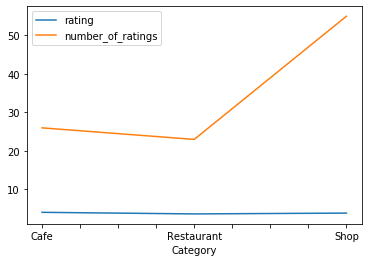

In [15]:
ratings.plot()


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
#ratings['rating'].hist(bins=30)

checking the relationship between the rating of a movie and the number of ratings. We do this by plotting a scatter plot using seaborn. Seaborn enables us to do this using the jointplot() function.

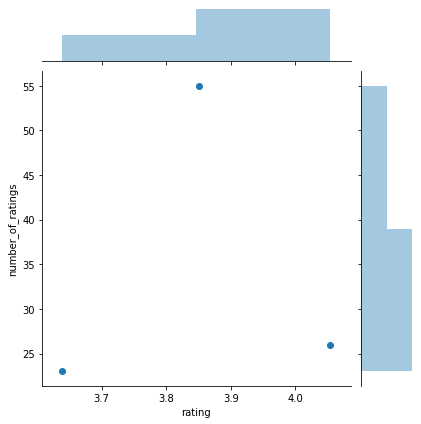

In [17]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=ratings)

creating a simple item based recommender system.
In order to do this we need to convert our dataset into a matrix with the Gender as the columns, the Name as the index and the ratings as the values.
By doing this we shall get a dataframe with the columns as the Gender  and the rows as the Name . Each column represents all the ratings of a Resturant/cage by all gender. The rating appear as NAN where a user didn't rate a certain Resturant/cage.  We use pandas pivot_table utility to create this matrix.

In [18]:
_matrix = df.pivot_table(index='Name', columns=['Type','Gender'], values='rating')


In [19]:
_matrix.head()

Type               Group        Solo     
Gender            Female Male Female Male
Name                                     
AMP Tshirt Store     4.0  4.0    NaN  NaN
Air Point            4.5  4.5    NaN  NaN
Astoria Kilo         NaN  4.5    4.5  NaN
BOB's                NaN  4.7    4.7  NaN
Banco Bradesco       NaN  2.1    2.1  NaN

we look at the most rated resturant/cafe and choose two of them to work with in this simple recommender system. We use pandas sort_values utility and set ascending to false in order to arrange the movies from the most rated. We then use the head() function to view the top 10.

In [20]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)


rating  number_of_ratings
Category                               
Shop        3.850909                 55
Cafe        4.053846                 26
Restaurant  3.639130                 23

In [21]:
_matrix.head()

Type               Group        Solo     
Gender            Female Male Female Male
Name                                     
AMP Tshirt Store     4.0  4.0    NaN  NaN
Air Point            4.5  4.5    NaN  NaN
Astoria Kilo         NaN  4.5    4.5  NaN
BOB's                NaN  4.7    4.7  NaN
Banco Bradesco       NaN  2.1    2.1  NaN

In [22]:
male_solo_user_rating = _matrix['Solo']['Male']


In [23]:
Female_solo_user_rating = _matrix['Solo']['Female']

In [24]:
Female_solo_user_rating_DF=pd.DataFrame(Female_solo_user_rating)
male_user_rating_DF=pd.DataFrame(Female_solo_user_rating)



In [25]:
Female_SOLO_lst=[]
for idx in range(len(Female_solo_user_rating)):
    cont=(str(Female_solo_user_rating_DF.iloc[idx]).replace('\n',' ').split(' '))
    if cont[4][0].isdigit():
        
        Female_SOLO_lst.append((cont[5]+' '+cont[6],cont[4]))
Female_SOLO_lst.sort(key=lambda x:x[1],reverse=True)
Female_SOLO_dict={}
for elem in Female_SOLO_lst:
    Female_SOLO_dict[elem[0].replace("Name: ","")]=elem[1]
import json
Female_SOLO_JSON = json.dumps(Female_SOLO_dict)
print(Female_SOLO_JSON)
    
    

{"BOB's": "4.7", "Hallah": "4.7", "Galeao": "4.6", "Astoria": "4.5", "Pastatore": "4.4", "Cafe": "4.2", "Bazar": "4.0", "Dartel": "4.0", "Do": "4.0", "Dufry": "4.0", "Engraxataria": "4.0", "Gatos": "4.0", "H.": "4.0", "Havaianas": "4.0", "La": "4.0", "Zeppelin": "4.0", "Santos": "3.85", "Kafe": "3.4", "O": "3.4", "Sobral,": "2.666667", "Viena": "2.4", "Banco": "2.1", "Katz": "2.0"}


In [26]:
lst=male_solo_user_rating.to_string().split("          ")
res=''
for elem in lst:
    res+=(elem)
val=res.split("\n")
temp=[]
for elem in val:
    if 'NaN' not in elem:
        temp.append(elem.replace('  ','\n'))
temp1=[]
male_solo_user_dic={}
for elem in temp:
    if "\n" in elem:
        val=elem.split("\n")
        male_solo_user_dic[val[0]]=float(''.join(val[1:]).strip())
sorted_x = sorted(male_solo_user_dic.items(), key=lambda kv: kv[1],reverse=True)
d={}
for elem in sorted_x:
    d[elem[0]]=elem[1]
import json
male_SOLO_JSON = json.dumps(d)
print(male_SOLO_JSON)
    

{"Palheta Air Cafe": 4.8, "Casa do Pao de Queijo": 4.7, "Palheta Popular Diner": 4.4, "Chocolate Q": 4.0, "FOM": 4.0, "It Beach": 4.0, "La Selva": 4.0, "Pedacinho de Minas by Rio": 4.0, "Tamar Flower Shop": 4.0, "Zeppelin Artes": 4.0, "O Boticario": 3.4, "Santos Dumont": 2.8, "Frango Assado": 2.6, "Viena": 2.4, "Katz Chocolates": 2.0}


In [27]:
Female_group_user_rating = _matrix['Group']['Female']

In [28]:
lst=Female_group_user_rating.to_string().split("          ")
res=''
for elem in lst:
    res+=(elem)
val=res.split("\n")
temp=[]
for elem in val:
    if 'NaN' not in elem:
        temp.append(elem.replace('  ','\n'))
temp1=[]
male_solo_user_dic={}
for elem in temp:
    if "\n" in elem:
        val=elem.split("\n")
        male_solo_user_dic[val[0]]=float(''.join(val[1:]).strip())
sorted_x = sorted(male_solo_user_dic.items(), key=lambda kv: kv[1],reverse=True)
d={}
for elem in sorted_x:
    d[elem[0]]=elem[1]
import json
male_SOLO_JSON = json.dumps(d)
print(male_SOLO_JSON)

{"Batata Inglesa": 4.9, "Palheta Air Cafe": 4.8, "Casa do Pao de Queijo": 4.7, "Hallah": 4.7, "Rei do Mate": 4.5, "Palheta Popular Diner": 4.4, "Spoleto": 4.1, "AMP Tshirt Store": 4.0, "Chilli Beans": 4.0, "Chocolate Q": 4.0, "Doarel": 4.0, "Emporio do Aco": 4.0, "Engraxataria do Presente": 4.0, "FOM": 4.0, "H. Stern": 4.0, "Linha do Horizonte": 4.0, "Pedacinho de Minas by Rio": 4.0, "Tamar Flower Shop": 4.0, "Sobral": 3.5, "Frango Assado": 2.6}


In [29]:
male_group_user_rating = _matrix['Group']['Male']

In [30]:
lst=male_group_user_rating.to_string().split("          ")
res=''
for elem in lst:
    res+=(elem)
val=res.split("\n")
temp=[]
for elem in val:
    if 'NaN' not in elem:
        temp.append(elem.replace('  ','\n'))
temp1=[]
male_solo_user_dic={}
for elem in temp:
    if "\n" in elem:
        val=elem.split("\n")
        male_solo_user_dic[val[0]]=float(''.join(val[1:]).strip())
sorted_x = sorted(male_solo_user_dic.items(), key=lambda kv: kv[1],reverse=True)
d={}
for elem in sorted_x:
    d[elem[0]]=elem[1]
import json
male_SOLO_JSON = json.dumps(d)
print(male_SOLO_JSON)

{"Batata Inglesa": 4.9, "BOB's": 4.7, "Galeao Coffee Shop": 4.6, "Astoria Kilo": 4.5, "Rei do Mate": 4.5, "Cafe Aviador": 4.2, "Spoleto": 4.1, "AMP Tshirt Store": 4.0, "Bazar Solidario": 4.0, "Chilli Beans": 4.0, "Dartel Toys": 4.0, "Doarel": 4.0, "Dufry": 4.0, "It Beach": 4.0, "Linha do Horizonte": 4.0, "Sobral": 4.0, "Cafe Palheta": 3.7, "Kafe": 3.4, "O Melhor Bolo de Chocolate do Mundo": 3.2, "Banco Bradesco": 2.1}


In [31]:
#correlation between Female Solo User ratings and the rest of the ratings.
similar_to_Female=_matrix.corr(method='pearson', min_periods=4)


#A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. The Pearson correlation is also known as the “product moment correlation coefficient” (PMCC) or simply “correlation”.

In [32]:
cat_matrix = df.pivot_table(index='Gender', columns='Name', values='rating')


RS based on Group vs SOlo

In [33]:
# second implementaion


In [34]:
modified_df=pd.DataFrame(df)
highest_rating=modified_df.sort_values('rating', ascending=False)
high = highest_rating.loc[:]
high.head(20)

Name    Category  rating  Gender   Type
99                  Sobral        Shop     5.0  Female  Group
79         Batata Inglesa   Restaurant     4.9  Female  Group
50           Santos Dumont  Restaurant     4.9  Female   Solo
28         Batata Inglesa   Restaurant     4.9    Male  Group
23       Palheta Air Cafe         Cafe     4.8  Female  Group
74       Palheta Air Cafe         Cafe     4.8    Male   Solo
43  Casa do Pao de Queijo         Cafe     4.7  Female  Group
68                  BOB's         Cafe     4.7    Male  Group
17                  BOB's         Cafe     4.7  Female   Solo
8                  Hallah   Restaurant     4.7  Female   Solo
94  Casa do Pao de Queijo         Cafe     4.7    Male   Solo
59                 Hallah   Restaurant     4.7  Female  Group
40     Galeao Coffee Shop         Cafe     4.6    Male  Group
91     Galeao Coffee Shop         Cafe     4.6  Female   Solo
0            Astoria Kilo         Cafe     4.5    Male  Group
20            Rei do Mate         Cafe     4.5    Male  Group
5               Air Point         Cafe     4.5  Female  Group
71            Rei do Mate         Cafe     4.5  Female  Group
51           Astoria Kilo         Cafe     4.5  Female   Solo
56              Air Point         Cafe     4.5    Male  Group

In [35]:
Solo = high[high['Type']== 'Solo']
Solo.values.tolist()[:10]

[['Santos Dumont', 'Restaurant', 4.9, 'Female', 'Solo'],
 ['Palheta Air Cafe ', 'Cafe', 4.8, 'Male', 'Solo'],
 ["BOB's ", 'Cafe', 4.7, 'Female', 'Solo'],
 ['Hallah ', 'Restaurant', 4.7, 'Female', 'Solo'],
 ['Casa do Pao de Queijo ', 'Cafe', 4.7, 'Male', 'Solo'],
 ['Galeao Coffee Shop ', 'Cafe', 4.6, 'Female', 'Solo'],
 ['Astoria Kilo ', 'Cafe', 4.5, 'Female', 'Solo'],
 ['Pastatore ', 'Restaurant', 4.4, 'Male', 'Solo'],
 ['Pastatore ', 'Restaurant', 4.4, 'Female', 'Solo'],
 ['Palheta Popular Diner ', 'Restaurant', 4.4, 'Male', 'Solo']]

In [36]:
highest_rating.corr(method='pearson', min_periods=4)


rating
rating     1.0

In [37]:
Group = high[high['Type']== 'Group' ]
Group.values.tolist()[:10]

[['Sobral', 'Shop', 5.0, 'Female', 'Group'],
 ['Batata Inglesa ', 'Restaurant', 4.9, 'Female', 'Group'],
 ['Batata Inglesa ', 'Restaurant', 4.9, 'Male', 'Group'],
 ['Palheta Air Cafe ', 'Cafe', 4.8, 'Female', 'Group'],
 ['Casa do Pao de Queijo ', 'Cafe', 4.7, 'Female', 'Group'],
 ["BOB's ", 'Cafe', 4.7, 'Male', 'Group'],
 ['Hallah ', 'Restaurant', 4.7, 'Female', 'Group'],
 ['Galeao Coffee Shop ', 'Cafe', 4.6, 'Male', 'Group'],
 ['Astoria Kilo ', 'Cafe', 4.5, 'Male', 'Group'],
 ['Rei do Mate ', 'Cafe', 4.5, 'Male', 'Group']]


Method to take two equally-sized lists and return just the elements which lie 
on the Pareto frontier, sorted into order.
Default behaviour is to find the maximum for both X and Y, but the option is
available to specify maxX = False or maxY = False to find the minimum for either
or both of the parameters.


In [38]:
def pareto_frontier(Xs, Ys, maxX = True, maxY = True):
# Sort the list in either ascending or descending order of X
    myList = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxX)
# Start the Pareto frontier with the first value in the sorted list
    p_front = [myList[0]]    
# Loop through the sorted list
    for pair in myList[1:]:
        if maxY: 
            if pair[1] >= p_front[-1][1]: # Look for higher values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
        else:
            if pair[1] <= p_front[-1][1]: # Look for lower values of Y…
                p_front.append(pair) # … and add them to the Pareto frontier
# Turn resulting pairs back into a list of Xs and Ys
    p_frontX = [pair[0] for pair in p_front]
    p_frontY = [pair[1] for pair in p_front]
    return p_frontX, p_frontY

In [39]:
pareto_frontier


<function __main__.pareto_frontier(Xs, Ys, maxX=True, maxY=True)>